# # Modelagem 1-dim 64 MFCCs

In [1]:
import keras as K
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from random import choice

from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

%matplotlib inline

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
DIR_DATAFRAMES = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/DATAFRAMES'
DIR_MFCC = '/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC'

In [4]:
!ls -lah $DIR_DATAFRAMES

total 4,1G
drwxrwxrwx 1 hbrandao hbrandao 4,0K mar 21 23:15 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 21 23:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 181K mar 21 23:27 Xfusao.csv
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 372M mar 23 00:32 Xsinal.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_stretch_0padded.npy
-rwxrwxrwx 1 hbrandao hbrandao 1,3G mar 23 00:32 Xsinal_tile_0padded.npy


In [5]:
!ls -lahR $DIR_MFCC

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC:
total 0
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:49 .
drwxrwxrwx 1 hbrandao hbrandao 0 mar 21 23:49 ..
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:55 128
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:54 64
drwxrwxrwx 1 hbrandao hbrandao 0 mar 22 01:53 mean

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/128:
total 944M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:55 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_pad_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:10 Xsinal_stretch_128mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 315M mar 22 02:11 Xsinal_tile_128mfcc.npy

/media/hbrandao/STORAGE_HDD_1TB/PPGI/BRAVO-DATAFRAMES/MFCC/64:
total 472M
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:54 .
drwxrwxrwx 1 hbrandao hbrandao    0 mar 22 01:49 ..
-rwxrwxrwx 1 hbrandao hbrandao 158M mar 22 02:05 Xsinal_pad_64mfcc.npy
-rwxrwxrwx 1 hbrandao hbrandao 158M 

In [6]:
PHYS_DEVICE_NAME = tf.config.list_physical_devices('GPU')[0].name[-5:]
if PHYS_DEVICE_NAME:
    print(PHYS_DEVICE_NAME)
else:
    raise Exception('GPU não encontrada')

GPU:0


2023-04-07 19:28:52.999726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 19:28:53.017829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-07 19:28:53.017972: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dados
___

In [7]:
X64 = np.load(f'{DIR_MFCC}/mean/Xsinal_64mfcc_mean.npy')

x64train, x64test, *_ = train_test_split(X64)
x64train.shape, x64test.shape

((1023, 64), (341, 64))

## Autoencoder
___

In [8]:
dim = X64.shape[-1]

In [9]:
def autoencoder64():
    inp_enc = K.Input(batch_shape=(1,dim))
    enc = layers.Dense(units=int(dim/2), activation='relu')(inp_enc)
    encoder = K.Model(inp_enc, enc)

    inp_dec = K.Input(batch_shape=(1,int(dim/2)))
    dec = layers.Dense(units=dim, activation='linear')(inp_dec)
    decoder = K.Model(inp_dec, dec)

    inp_ae = K.Input(batch_shape=(1,dim))
    enc_ae = encoder(inp_ae)
    dec_ae = decoder(enc_ae)

    ae = K.Model(inp_ae, dec_ae, name='autoencoder')
    ae.compile(optimizer='adam', loss='mse', metrics=['mae'])

    return ae, encoder, decoder

### x64 train

In [13]:
# epochs = 1000

# es = EarlyStopping(monitor='loss', mode='min', min_delta=0.01, patience=20, verbose=1)

# mc = ModelCheckpoint('autoencoder_mean_64mfcc.hdf5',
#                      monitor='loss', verbose=1, save_best_only=True, mode='min')

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     modelo64, encoder64, decoder64 = autoencoder64()
#     history = modelo64.fit(x=x64train,
#                            y=x64train,
#                            epochs=epochs,
#                            batch_size=10,
#                            shuffle=True,
#                            validation_data=(x64test, x64test),
#                            callbacks=[es, mc]
#                           )

Epoch 1/1000
103/103 [==============================] - 0s 2ms/step - loss: 1934.7291 - mae: 16.3917 - val_loss: 754.7725 - val_mae: 10.1415

Epoch 00001: loss improved from inf to 1934.72913, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 2/1000
103/103 [==============================] - 0s 1ms/step - loss: 273.8285 - mae: 7.8965 - val_loss: 108.7649 - val_mae: 6.6208

Epoch 00002: loss improved from 1934.72913 to 273.82849, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 3/1000
103/103 [==============================] - 0s 1ms/step - loss: 94.5508 - mae: 6.3142 - val_loss: 84.7504 - val_mae: 5.9852

Epoch 00003: loss improved from 273.82849 to 94.55085, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 4/1000
103/103 [==============================] - 0s 1ms/step - loss: 74.9090 - mae: 5.7692 - val_loss: 67.3958 - val_mae: 5.4965

Epoch 00004: loss improved from 94.55085 to 74.90895, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 5/1000
103/103 [==========================


Epoch 00035: loss improved from 11.88637 to 11.71822, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 36/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.5654 - mae: 2.4884 - val_loss: 11.6603 - val_mae: 2.5044

Epoch 00036: loss improved from 11.71822 to 11.56536, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 37/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.3503 - mae: 2.4676 - val_loss: 11.3379 - val_mae: 2.4676

Epoch 00037: loss improved from 11.56536 to 11.35030, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 38/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.2206 - mae: 2.4466 - val_loss: 11.2221 - val_mae: 2.4530

Epoch 00038: loss improved from 11.35030 to 11.22063, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 39/1000
103/103 [==============================] - 0s 1ms/step - loss: 11.1142 - mae: 2.4340 - val_loss: 11.0039 - val_mae: 2.4407

Epoch 00039: loss improved from 11.22063 to 11.1142

103/103 [==============================] - 0s 1ms/step - loss: 7.4465 - mae: 1.9769 - val_loss: 7.7140 - val_mae: 2.0069

Epoch 00071: loss improved from 7.51692 to 7.44650, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 72/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.4584 - mae: 1.9739 - val_loss: 7.4955 - val_mae: 1.9728

Epoch 00072: loss did not improve from 7.44650
Epoch 73/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.3416 - mae: 1.9553 - val_loss: 7.5899 - val_mae: 1.9937

Epoch 00073: loss improved from 7.44650 to 7.34163, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 74/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2990 - mae: 1.9477 - val_loss: 7.5843 - val_mae: 1.9863

Epoch 00074: loss improved from 7.34163 to 7.29900, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 75/1000
103/103 [==============================] - 0s 1ms/step - loss: 7.2747 - mae: 1.9437 - val_loss: 7.4647 - val_mae: 1.97

103/103 [==============================] - 0s 1ms/step - loss: 6.5669 - mae: 1.8315 - val_loss: 6.7483 - val_mae: 1.8558

Epoch 00109: loss improved from 6.58902 to 6.56689, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 110/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4784 - mae: 1.8153 - val_loss: 6.8450 - val_mae: 1.8668

Epoch 00110: loss improved from 6.56689 to 6.47837, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 111/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.5055 - mae: 1.8217 - val_loss: 6.7785 - val_mae: 1.8561

Epoch 00111: loss did not improve from 6.47837
Epoch 112/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4998 - mae: 1.8195 - val_loss: 6.7793 - val_mae: 1.8783

Epoch 00112: loss did not improve from 6.47837
Epoch 113/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.4885 - mae: 1.8203 - val_loss: 6.7175 - val_mae: 1.8442

Epoch 00113: loss did not improve from 6.4


Epoch 00149: loss did not improve from 6.22199
Epoch 150/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.1696 - mae: 1.7701 - val_loss: 6.6664 - val_mae: 1.8527

Epoch 00150: loss improved from 6.22199 to 6.16959, saving model to autoencoder_mean_64mfcc.hdf5
Epoch 151/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2380 - mae: 1.7810 - val_loss: 6.5294 - val_mae: 1.8189

Epoch 00151: loss did not improve from 6.16959
Epoch 152/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2434 - mae: 1.7830 - val_loss: 6.6383 - val_mae: 1.8347

Epoch 00152: loss did not improve from 6.16959
Epoch 153/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2662 - mae: 1.7808 - val_loss: 6.6215 - val_mae: 1.8418

Epoch 00153: loss did not improve from 6.16959
Epoch 154/1000
103/103 [==============================] - 0s 1ms/step - loss: 6.2786 - mae: 1.7880 - val_loss: 6.5169 - val_mae: 1.8196

Epoch 00154: loss did not imp

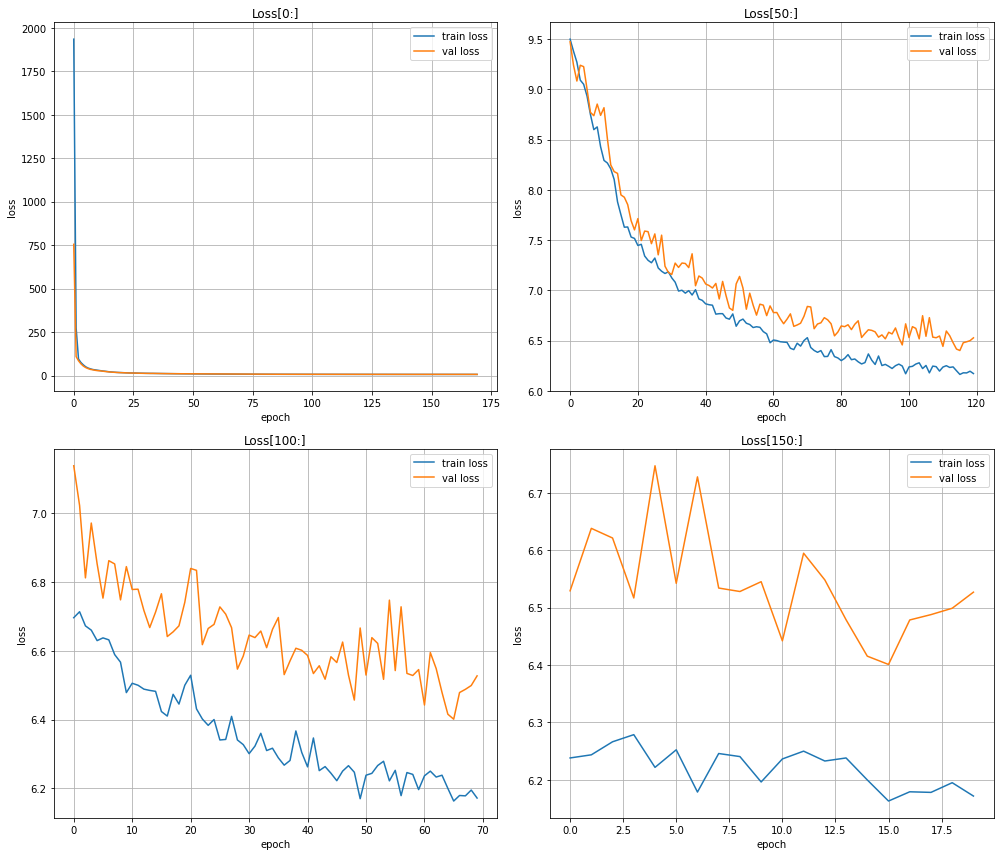

In [14]:
plt.figure(figsize=(14, 12))

row, col = 2, 2

for i,r in enumerate((0, 50, 100, 150)):
    plt.subplot(row,col,i+1)
    plt.plot(history.history['loss'][r:])
    plt.plot(history.history['val_loss'][r:])
    plt.title(f'Loss[{r}:]')
    plt.legend(['train loss', 'val loss'], loc='upper right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()

plt.tight_layout()
plt.show()

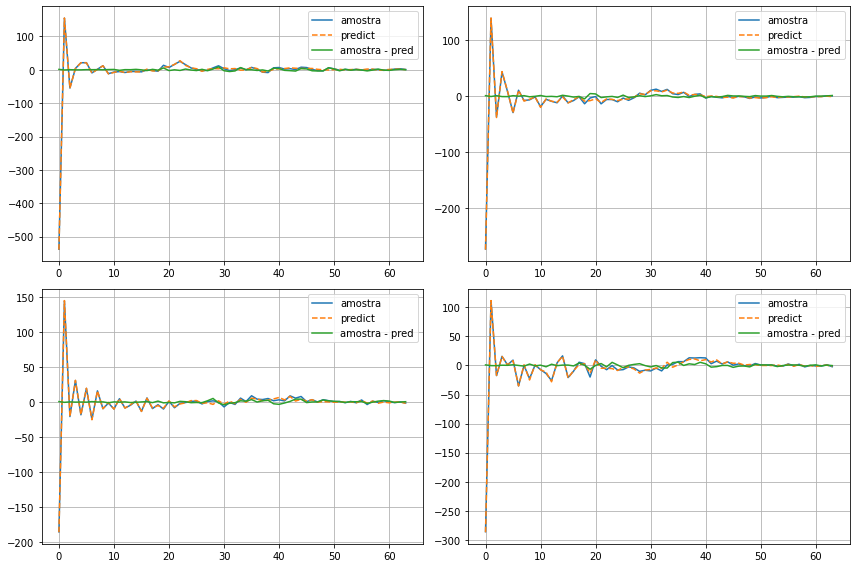

In [15]:
plt.figure(figsize=(12,8))

row, col, idx = 2, 2, 1

for i in range(row*col):
    reg = choice(x64train).reshape(1,dim)
    pred = modelo64.predict(reg)
    diff = reg - pred

    plt.subplot(row, col, idx)
    plt.plot(reg.flatten(), label='amostra')
    plt.plot(pred.flatten(), label='predict', linestyle='--')
    plt.plot(diff.flatten(), label='amostra - pred')
    plt.legend()
    plt.grid()
    idx += 1

plt.tight_layout()
plt.show()

In [16]:
pred_x64 = modelo64.predict(x64test)
loss_x64 = K.losses.mse(pred_x64, x64test)

np.mean(loss_x64)

6.5270452

In [18]:
#
#
modelo64 = K.models.load_model('autoencoder_mean_64mfcc.hdf5')
#
#

### x64 train MinMax scaled

In [19]:
# x64scaled = MinMaxScaler().fit_transform(X64)
# x64train_scaled, x64test_scaled, *_ = train_test_split(X64)

# x64train_scaled.shape, x64test_scaled.shape

In [20]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     modelo64_scaled, *_ = autoencoder64()
#     history = modelo64_scaled.fit(x=x64train_scaled,
#                                   y=x64train_scaled,
#                                   epochs=epochs,
#                                   batch_size=10,
#                                   shuffle=True,
#                                   validation_data=(x64test_scaled, x64test_scaled),
#                                   callbacks=[es])

In [21]:
# plt.figure(figsize=(14, 12))

# row, col = 2, 2

# for i,r in enumerate((0, 50, 100, 150)):
#     plt.subplot(row,col,i+1)
#     plt.plot(history.history['loss'][r:])
#     plt.plot(history.history['val_loss'][r:])
#     plt.title(f'Loss[{r}:]')
#     plt.legend(['train loss', 'val loss'], loc='upper right')
#     plt.xlabel('epoch')
#     plt.ylabel('loss')
#     plt.grid()

# plt.tight_layout()
# plt.show()

In [22]:
# plt.figure(figsize=(12,8))

# row, col, idx = 2, 2, 1

# for i in range(row*col):
#     reg = choice(x64train_scaled).reshape(1,dim)
#     pred = modelo64_scaled.predict(reg)
#     diff = reg - pred

#     plt.subplot(row, col, idx)
#     plt.plot(reg.flatten(), label='amostra_scaled')
#     plt.plot(pred.flatten(), label='predict_scaled', linestyle='--')
#     plt.plot(diff.flatten(), label='amostra_scaled - pred_scaled')
#     plt.legend()
#     plt.grid()
#     idx += 1

# plt.tight_layout()
# plt.show()

In [23]:
# pred_x64_scaled = modelo64_scaled.predict(x64test_scaled)
# loss_x64_scaled = K.losses.mse(pred_x64_scaled, x64test_scaled)

# np.mean(loss_x64_scaled)

#### Tentando um Autoencoder mais profundo

In [24]:
# def deep_autoencoder64():
#     K.backend.clear_session()

#     input64 = K.Input(batch_shape=(1,dim))

#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(input64)
#     encoder64 = layers.Dropout(0.25)(encoder64)
#     encoder64 = layers.Dense(units=int(dim/2), activation='relu')(encoder64)

#     decoder64 = layers.Dropout(0.25)(encoder64)
#     decoder64 = layers.Dense(units=int(dim/2), activation='relu')(decoder64)
#     decoder64 = layers.Dropout(0.25)(decoder64)
#     decoder64 = layers.Dense(units=dim, activation='linear')(decoder64)

#     ae64 = K.Model(input64, decoder64, name='deep_autoencoder64')
#     ae64.compile(optimizer='adam', loss='mse', metrics=['mae'])

#     print(ae64.summary())

#     return ae64

# deep_autoencoder64()

In [25]:
# epochs = 1000

# es = EarlyStopping(monitor='loss',
#                    mode='min',
#                    min_delta=0.01,
#                    patience=20,
#                    verbose=1)

# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     deep_modelo64 = deep_autoencoder64()
#     history = deep_modelo64.fit(x=x64train,
#                                 y=x64train,
#                                 epochs=epochs,
#                                 batch_size=10,
#                                 shuffle=True,
#                                 validation_data=(x64test, x64test),
#                                 callbacks=[es],
#                                )

In [26]:
# np.mean(
#     K.losses.mse(deep_modelo64.predict(x64test), x64test)
# )

Dados os experimentos, podemos assumir que o Autoencoder (`modelo64`) com dados não normalizados apresenta a melhor performance

In [27]:
# del x64train, x64test
# del x64scaled, x64train_scaled, x64test_scaled
# del modelo64_scaled, deep_modelo64

## Classificador

In [28]:
X64.shape

(1364, 64)

In [29]:
Xfusao = pd.read_csv(f'{DIR_DATAFRAMES}/Xfusao.csv', delimiter=';')
Xfusao.shape

(1364, 8)

In [30]:
Xfusao.head()

,path,dataset,arquivo,pessoa,genero,emocao,intensidade,duracao
0,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l1.wav,f1,f,alegria,NaN,2.451610
1,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l2.wav,f1,f,alegria,NaN,3.916553
2,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l3.wav,f1,f,alegria,NaN,3.482993
3,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l4.wav,f1,f,alegria,NaN,3.684354
4,/media/hbrandao/STORAGE_HDD_1TB/PPGI/VERBO/Aud...,verbo,ale-f1-l5.wav,f1,f,alegria,NaN,2.343061


In [31]:
DE_PARA_EMOCAO = {
    'alegria': np.array([1,0,0,0]),
    'medo': np.array([0,1,0,0]),
    'raiva': np.array([0,0,1,0]),
    'surpresa': np.array([0,0,0,1]),
}

DE_PARA_INTENSIDADE = {
    'fraca': np.array([1,0,0,0]),
    'moderada': np.array([0,1,0,0]),
    'forte': np.array([0,0,1,0]),
    'pico': np.array([0,0,0,1]),
}

def encoding_emocao(emocao: str):
    return DE_PARA_EMOCAO.get(emocao)

def encoding_intensidade(intensidade: str):
    return DE_PARA_INTENSIDADE.get(intensidade)

In [32]:
Xfusao['emo'] = Xfusao['emocao'].apply(encoding_emocao)
Xfusao['int'] = Xfusao['intensidade'].apply(encoding_intensidade)

In [33]:
Xfusao.drop(labels=['path', 'pessoa', 'genero', 'duracao', 'emocao', 'intensidade'],
            axis=1, inplace=True)

In [34]:
Xfusao.tail()

,dataset,arquivo,emo,int
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]"
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]"
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]"
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]"


In [35]:
Xfusao = pd.concat(objs=[Xfusao, pd.DataFrame(X64)], axis=1)
Xfusao.tail()

,dataset,arquivo,emo,int,0,1,2,3,4,5,...,54,55,56,57,58,59,60,61,62,63
1359,vivae,S11_surprise_low_03.wav,"[0, 0, 0, 1]","[1, 0, 0, 0]",-429.589874,133.411682,-50.135876,-2.183036,-23.552435,16.127447,...,-0.139971,2.148980,0.202220,3.275567,-0.529448,-0.181059,4.731008,0.363102,0.874546,2.543077
1360,vivae,S11_surprise_moderate_01.wav,"[0, 0, 0, 1]","[0, 1, 0, 0]",-464.718903,134.753693,-7.355528,23.141539,-41.095829,-12.439143,...,3.822853,2.926050,-2.851189,3.309691,0.376164,-0.513694,1.384362,2.246764,0.847502,-1.558109
1361,vivae,S11_surprise_peak_04.wav,"[0, 0, 0, 1]","[0, 0, 0, 1]",-335.451172,-14.470435,-37.541733,-11.240404,-18.821291,18.479385,...,0.819087,-0.181811,1.292265,-1.130435,5.381464,-1.318466,-2.149301,3.814080,-0.214485,2.099050
1362,vivae,S11_surprise_strong_011.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-282.711945,70.662437,-39.934624,-4.440723,-53.481644,-15.649154,...,1.302397,-0.589643,-0.325025,5.137481,2.956725,-3.193030,-2.849084,5.133433,3.861740,0.229049
1363,vivae,S11_surprise_strong_012.wav,"[0, 0, 0, 1]","[0, 0, 1, 0]",-399.486450,103.588158,-58.144569,-14.114857,-41.650688,10.208106,...,1.302480,1.885603,-0.327338,-0.116328,2.800063,3.395798,-0.581741,1.221288,1.824211,2.366567


In [36]:
Xfusao_verbo = Xfusao[Xfusao['dataset'] == 'verbo']
Xfusao_verbo.shape

(666, 68)

In [37]:
Xfusao_vivae = Xfusao[Xfusao['dataset'] == 'vivae']
Xfusao_vivae.shape

(698, 68)

In [38]:
def realizar_encoding(x, dim=dim):
    return encoder64(x.reshape(1,dim).astype('float32'))

In [39]:
x64_vivae_enc = np.array([realizar_encoding(x) for x in Xfusao_vivae.values[:,4:]])
x64_vivae_enc.shape

(698, 1, 32)

In [40]:
y64_vivae = np.array([x.reshape(1,4) for x in Xfusao_vivae['int'].values])
y64_vivae.shape

(698, 1, 4)

In [41]:
xtrain, xtest, ytrain, ytest = train_test_split(x64_vivae_enc, y64_vivae)

xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((523, 1, 32), (523, 1, 4), (175, 1, 32), (175, 1, 4))

### Modelo

In [42]:
def modelo_clf_intensidade():
    K.backend.clear_session()
    modelo = K.Sequential()
    modelo.add(layers.Dense(units=32, activation='relu', input_shape=(1,32)))
    modelo.add(layers.Dense(units=16, activation='relu'))
    modelo.add(layers.Dense(units=8, activation='relu'))
    modelo.add(layers.Dense(units=4, activation='softmax'))

    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(modelo.summary())
    return modelo

modelo_clf_intensidade()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
# epochs = 1000

# es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=0.001, patience=20, verbose=1)

# mc = ModelCheckpoint('classificador_intensidade_64mfcc_encoded.hdf5',
#                      monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


# with tf.device(PHYS_DEVICE_NAME):
#     K.backend.clear_session()
#     clf_intensidade = modelo_clf_intensidade()
#     history = clf_intensidade.fit(x=xtrain,
#                                   y=ytrain,
#                                   epochs=epochs,
#                                   batch_size=2,
#                                   shuffle=True,
#                                   validation_data=(xtest, ytest),
#                                   callbacks=[es, mc]
#                                  )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 32)             1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1, 16)             528       
_________________________________________________________________
dense_2 (Dense)              (None, 1, 8)              136       
_________________________________________________________________
dense_3 (Dense)              (None, 1, 4)              36        
Total params: 1,756
Trainable params: 1,756
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
262/262 [==============================] - 1s 3ms/step - loss: 3.4238 - accuracy: 0.3480 - val_loss: 1.8579 - val_accuracy: 0.3543

Epoch 00001: val_accuracy improved from -inf to 0.35429, saving model to classificador_intensidade_64m

262/262 [==============================] - 1s 2ms/step - loss: 0.7638 - accuracy: 0.6520 - val_loss: 1.2730 - val_accuracy: 0.5200

Epoch 00036: val_accuracy did not improve from 0.53143
Epoch 37/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.7618 - accuracy: 0.6501 - val_loss: 1.1800 - val_accuracy: 0.5029

Epoch 00037: val_accuracy did not improve from 0.53143
Epoch 38/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.7290 - accuracy: 0.6597 - val_loss: 1.2153 - val_accuracy: 0.4857

Epoch 00038: val_accuracy did not improve from 0.53143
Epoch 39/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.7900 - accuracy: 0.6482 - val_loss: 1.2696 - val_accuracy: 0.4686

Epoch 00039: val_accuracy did not improve from 0.53143
Epoch 40/1000
262/262 [==============================] - 1s 2ms/step - loss: 0.7652 - accuracy: 0.6291 - val_loss: 1.2019 - val_accuracy: 0.4971

Epoch 00040: val_accuracy did not improve from 0.53143
Epoch 41/

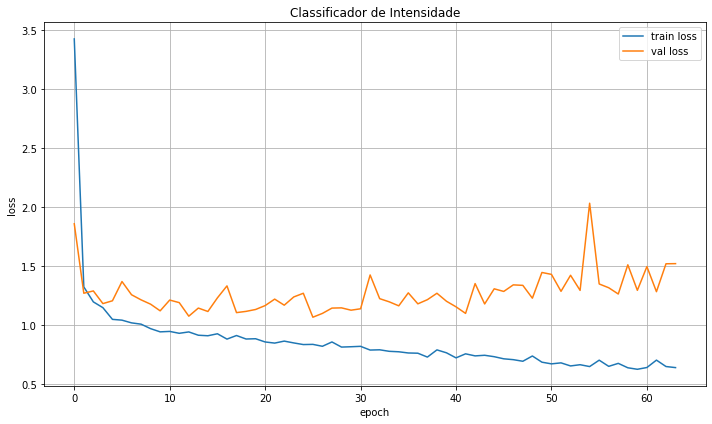

In [62]:
plt.figure(figsize=(10, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train loss', 'val loss'], loc='upper right')
plt.title('Classificador de Intensidade')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.tight_layout()
plt.show()

In [63]:
_ = classification_report(
    y_true=[np.argmax(x) for x in ytest],
    y_pred=[np.argmax(x) for x in clf_intensidade.predict(xtest)],
    target_names=DE_PARA_INTENSIDADE.keys()
)

print(_)

              precision    recall  f1-score   support

       fraca       0.57      0.62      0.59        42
    moderada       0.38      0.27      0.32        48
       forte       0.43      0.44      0.43        48
        pico       0.59      0.73      0.65        37

    accuracy                           0.50       175
   macro avg       0.49      0.51      0.50       175
weighted avg       0.48      0.50      0.49       175



In [64]:
#
#
clf_intensidade = K.models.load_model('classificador_intensidade_64mfcc_encoded.hdf5')
#
#

In [65]:
_ = classification_report(
    y_true=[np.argmax(x) for x in ytest],
    y_pred=[np.argmax(x) for x in clf_intensidade.predict(xtest)],
    target_names=DE_PARA_INTENSIDADE.keys(),
    zero_division=0
)

print(_)

              precision    recall  f1-score   support

       fraca       0.64      0.60      0.62        42
    moderada       0.47      0.56      0.51        48
       forte       0.49      0.35      0.41        48
        pico       0.59      0.70      0.64        37

    accuracy                           0.54       175
   macro avg       0.55      0.55      0.55       175
weighted avg       0.54      0.54      0.54       175



#### VERBO

In [66]:
xtest_verbo = np.array([realizar_encoding(x) for x in Xfusao_verbo.values[:,4:]])
pred_verbo = [np.argmax(x) for x in clf_intensidade.predict(xtest_verbo)]

In [67]:
np.array(pred_verbo)

array([1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0,
       1, 1, 3, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 3, 2, 1, 1, 1,
       2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 0, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 3,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 2, 1, 2, 3, 2, 2, 3, 1, 3, 2, 2, 1, 1,
       1, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 2, 0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 3, 0, 2, 0, 1,
       0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Decomposição

In [68]:
LABEL_INTENSIDADE = {
    0: 'fraca',
    1: 'moderada',
    2: 'forte',
    3: 'pico'
}

In [69]:
pred_verbo_label = [LABEL_INTENSIDADE.get(_) for _ in pred_verbo]

In [70]:
pred_vivae_label = [
        LABEL_INTENSIDADE.get(np.argmax(x)) for x in clf_intensidade.predict(x64_vivae_enc)
]

In [71]:
x64_vivae_enc.shape, xtest_verbo.shape

((698, 1, 32), (666, 1, 32))

In [72]:
x64_vivae_enc[0].shape, x64_vivae_enc[0]

((1, 32),
 array([[ 38.32755  ,  29.597744 ,  20.504797 ,   0.       ,  25.20498  ,
          25.448265 ,   0.       ,  27.14567  ,  30.391798 ,   6.8496013,
           0.       ,  23.386211 ,   0.       ,   0.       ,  38.803898 ,
           0.       ,  73.87221  ,  77.22396  ,  39.77841  , 120.84111  ,
          31.767437 ,  20.960722 ,  97.8414   ,  75.88406  ,  66.22955  ,
           0.       ,  26.810492 ,  60.558372 ,   0.       ,  44.80686  ,
          38.209805 ,  27.5335   ]], dtype=float32))

In [73]:
xtest_verbo[0].shape, xtest_verbo[0]

((1, 32),
 array([[38.346786 , 25.852377 , 31.823423 ,  0.       , 24.756721 ,
         30.194794 ,  0.       , 23.555525 , 27.084318 , 45.691284 ,
          0.       , 17.752491 ,  0.       ,  0.       , 41.534237 ,
          0.       , 37.93264  , 21.619474 , 22.354967 , 31.472746 ,
         18.453602 , 34.242275 ,  7.4341154, 16.267134 , 19.421997 ,
          0.       , 18.305729 , 37.938187 ,  0.       , 38.049942 ,
         23.553957 , 15.187419 ]], dtype=float32))

In [74]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [75]:
x64_vivae_enc.shape

(698, 1, 32)

In [76]:
x64_vivae_enc.reshape(698,32)

array([[38.32755  , 29.597744 , 20.504797 , ..., 44.80686  , 38.209805 ,
        27.5335   ],
       [25.263147 , 30.855192 , 24.828438 , ..., 74.433685 , 29.368088 ,
        28.129478 ],
       [39.020767 , 29.36972  , 19.150225 , ..., 75.136635 , 33.434017 ,
        17.979809 ],
       ...,
       [ 7.5877285,  3.0577867, 13.532934 , ..., 27.190022 , 34.991875 ,
         4.156628 ],
       [30.613922 , 28.780169 , 21.059881 , ..., 15.054345 , 22.601492 ,
        21.933218 ],
       [29.468454 , 28.35612  , 22.991909 , ..., 50.07658  , 16.124937 ,
        16.404333 ]], dtype=float32)

In [77]:
xtest_verbo.shape

(666, 1, 32)

In [78]:
xtest_verbo.reshape(666,32)

array([[38.346786 , 25.852377 , 31.823423 , ..., 38.049942 , 23.553957 ,
        15.187419 ],
       [37.364872 , 25.288706 , 31.209166 , ..., 36.078396 , 19.817282 ,
         9.6982355],
       [38.466995 , 30.204102 , 17.765137 , ..., 33.22193  , 19.661682 ,
        14.583076 ],
       ...,
       [ 9.669919 ,  4.697946 ,  1.573931 , ..., 24.620773 , 13.038884 ,
         5.8627424],
       [16.59129  ,  6.569457 ,  8.583654 , ..., 18.115005 , 20.58534  ,
         6.6556115],
       [14.455152 ,  9.407586 ,  1.5063841, ..., 25.702929 , 17.260431 ,
         6.171638 ]], dtype=float32)

### PCA

@VIVAE MFCCs

In [93]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(Xfusao_vivae.values[:,4:])
Xpca.shape

(698, 2)

In [94]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [LABEL_INTENSIDADE.get(np.argmax(x)) for x in y64_vivae]
df_pca.head()

,c1,c2,label
0,133.956117,-30.721512,fraca
1,8.579295,20.402926,fraca
2,-1.521525,-6.958716,fraca
3,88.178866,-4.884545,fraca
4,11.177695,6.202114,fraca


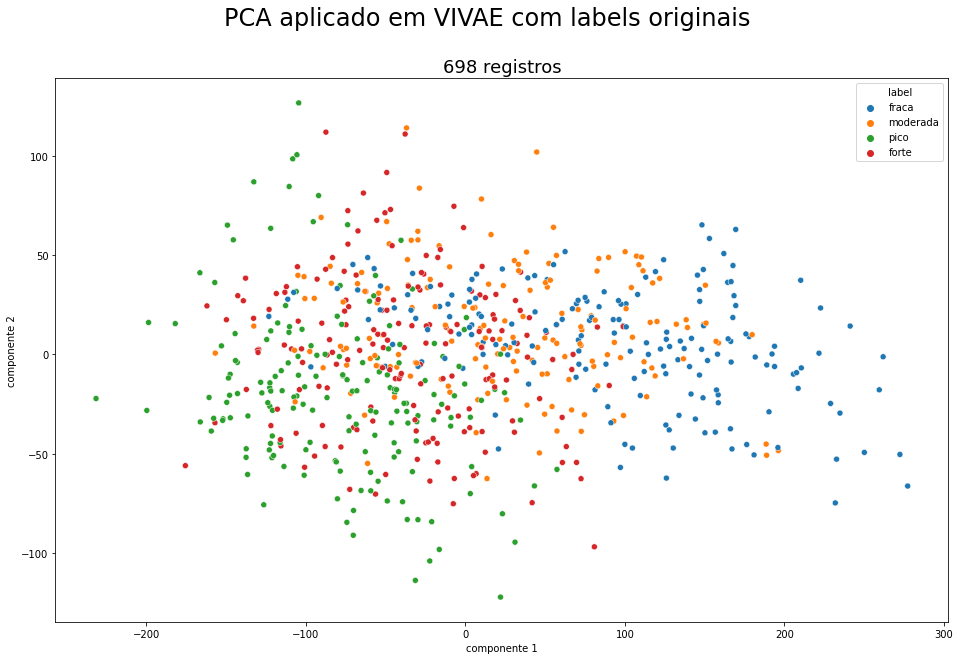

In [95]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado em VIVAE com labels originais', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1')
plt.ylabel('componente 2')

plt.show()

@VIVAE AE

In [96]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform([*x64_vivae_enc.reshape(698,32)])
Xpca.shape

(698, 2)

In [97]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [LABEL_INTENSIDADE.get(np.argmax(x)) for x in y64_vivae]
df_pca.head()

,c1,c2,label
0,73.641134,-27.658875,fraca
1,-2.135570,0.606451,fraca
2,-2.141232,-5.057831,fraca
3,48.188558,-24.579058,fraca
4,-2.460689,6.136816,fraca


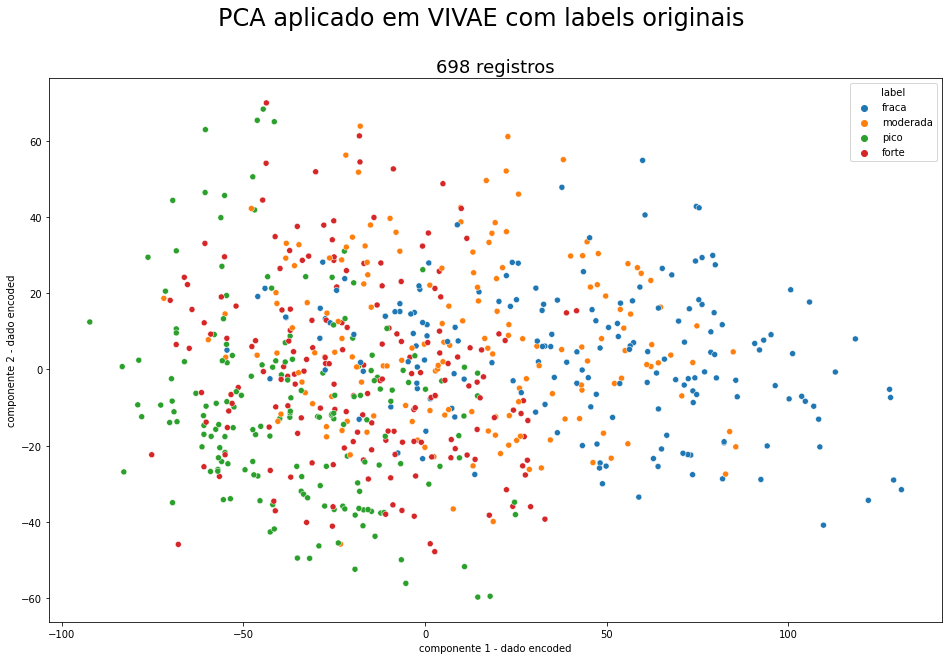

In [98]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado em VIVAE com labels originais', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1 - dado encoded')
plt.ylabel('componente 2 - dado encoded')

plt.show()

@AE VERBO e VIVAE

In [99]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform([*x64_vivae_enc.reshape(698,32), *xtest_verbo.reshape(666,32)])
Xpca.shape

(1364, 2)

In [100]:
df_pca = pd.DataFrame(data=Xpca, columns=('c1', 'c2'))
df_pca['label'] = [*pred_vivae_label, *[_ + ' (verbo)' for _ in pred_verbo_label]]
df_pca.head()

,c1,c2,label
0,100.500321,46.367870,fraca
1,49.755940,-12.928619,fraca
2,56.379690,-20.039450,moderada
3,82.726391,28.620103,fraca
4,58.837281,-22.756319,moderada


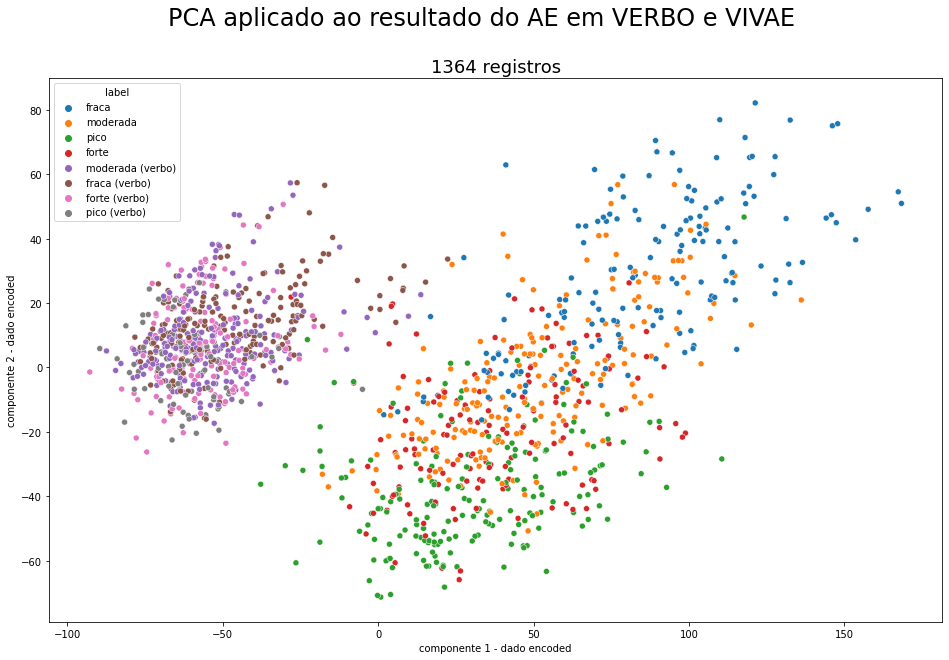

In [101]:
plt.figure(figsize=(16, 10))

sns.scatterplot(data=df_pca, x='c1', y='c2', hue='label')
plt.suptitle('PCA aplicado ao resultado do AE em VERBO e VIVAE', fontsize=24)
plt.title(f'{df_pca.shape[0]} registros', fontsize=18)
plt.xlabel('componente 1 - dado encoded')
plt.ylabel('componente 2 - dado encoded')

plt.show()

___
Refs:

- [62] https://sci-hub.se/10.1109/tmm.2017.2766843
- [63] https://sci-hub.se/10.1016/j.bspc.2018.08.035
- [64] https://arxiv.org/pdf/1712.08708.pdf
- [65] https://sci-hub.se/10.1109/icassp.2018.8462685
- [66] https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9136653
- [67] https://sci-hub.se/10.1109/ectidamtncon48261.2020.9090768
- [68] https://www.isca-speech.org/archive_v0/Interspeech_2019/pdfs/2561.pdf
- https://sci-hub.se/10.7717/peerj.488
